### **Aluna**: Lais de Souza Ziegler
# 🛳️ Predição de sobrevivência em Naufrágio
Dataset: treino.csv

O projeto de predição de sobrevivência em naufrágios utiliza um conjunto de dados inspirado em um incidente recente no Mediterrâneo, contendo informações sobre 7.124 passageiros a bordo de um navio. As variáveis incluem identificação única do passageiro, nome, informações da cabine (deck, número e posição), procedência, destino, idade, status de VIP, modalidade de hospedagem e gastos com serviços a bordo. O objetivo é prever a probabilidade de um passageiro sobreviver ao naufrágio com base em suas características.

### 1️⃣ Leitura e exploração dos dados
---
#### Importando as bibliotecas necessárias para a análise de dados

In [ ]:
# Pacotes básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Pacotes do Scikit-learn para acesso a datasets, preparação, modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, RocCurveDisplay, precision_score

# Pacotes para modelos de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier

#### Carregando o conjunto de dados a partir de um arquivo CSV
- Em seguida, imprimindo os tipos de dados de cada coluna para entender a estrutura do DataFrame
- Exibindo as primeiras cinco linhas do conjunto de dados para uma visão geral dos dados

In [ ]:
df = pd.read_csv("treino.csv")

df.info()
df.head()

#### Exibindo a forma do DataFrame, que retorna o número de linhas e colunas,

In [ ]:
print(df.shape)

#### Exibindo um resumo estatístico das colunas numéricas do DataFrame

In [ ]:
df.describe()

### Visualizar a proporção de sobreviventes na coluna Sobrevivente do dataset
Gráfico de pizza com proporções:
- Roxo: Sobreviventes.
- Amarelo: Não sobreviventes.

Proporção entre sobreviventes e vítimas é claramente visualizada. Isso nos ajuda a identificar possíveis tendências de desequilíbrio no dataset.
- O dataset possui um equilíbrio relativo entre sobreviventes e não sobreviventes, o que é favorável para treinar modelos de aprendizado supervisionado.

- A pequena diferença sugere que balanceamento adicional pode não ser necessário neste atributo.

In [ ]:
total_true = df['Sobrevivente'].sum()
total_false = len(df['Sobrevivente']) - total_true

labels = ['Sobreviventes', 'Vítimas']
sizes = [total_true, total_false]
colors = ['#9B59B6', '#F1C40F']
explode = (0.1, 0)

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True)

plt.title('Distribuição de Sobreviventes', fontsize=14)
plt.show()

### Verificando se há valores ausentes

In [ ]:
df.isnull().sum()

## Análise de Passageiros em Família e Solo
Identificar se os passageiros se estão viajando sozinhos ou em grupo (família) com base em um identificador fornecido.

- Separar o ID de Grupo e o Número do Integrante
    - Dividimos o identificador único de cada passageiro (`IDpassageiro`) em duas partes: o grupo ao qual o passageiro pertence e o número de cada integrante dentro desse grupo. Isso nos permite rastrear quantos passageiros fazem parte de cada grupo.

- Identificar se o Passageiro está em Família
    - Com a contagem de passageiros por grupo, marcamos os passageiros que pertencem a grupos com mais de um integrante como "Em Grupo", e os demais como "Solo".


In [ ]:
df[['Grupo', 'Integrante']] = df['IDpassageiro'].str.split('_', expand=True)

group_counts = df['Grupo'].value_counts()

df['EmGrupo'] = df['Grupo'].apply(lambda x: 1 if group_counts[x] > 1 else 0)

print(df.EmGrupo.value_counts())

### Visualizar a Distribuição de Passageiros em Família e Solo
Gráfico de barras para mostrar visualmente a quantidade de passageiros que viajam sozinhos em comparação aos que viajam em grupo, facilitando a análise da distribuição entre esses dois tipos de passageiros.

In [ ]:
plt.figure(figsize=(4, 2))
df['EmGrupo'].value_counts().plot(kind='bar', color = ['#9B59B6', '#F1C40F'] )
plt.xticks(ticks=[0, 1], labels=['Solo', 'Em Grupo'], rotation=0)
plt.title('Distribuição de Passageiros em Grupo e Solo')
plt.xlabel('Tipo de Passageiro')
plt.ylabel('Contagem')
plt.show()

### Visualizar a Distribuição de Passageiros por Deck
Mostrando visualmente a quantidade de passageiros em cada Deck do navio.

In [ ]:
deck_counts = df['Deck'].value_counts().reset_index()
deck_counts_sorted = deck_counts.sort_values(by='Deck', ascending=True)
deck_counts.columns = ['Deck', 'Contagem']

plt.figure(figsize=(4, 2))
sns.heatmap(deck_counts_sorted.set_index('Deck').T, annot=True, fmt='d', cmap='Purples', cbar=False, linewidths=1, linecolor='gray')

plt.title('Contagem de Passageiros por Deck', fontsize=16)
plt.xlabel('Deck', fontsize=12)
plt.show()

### Visualizar a Distribuição de Passageiros e a Posição da Cabine
Mostrando visualmente a quantidade de passageiros em cada Deck do navio.

In [ ]:
# Gráfico de pizza com cores personalizadas
plt.figure(figsize=(4, 4))
df['PosicaoCabine'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#9B59B6', '#F1C40F'], startangle=90, explode=(0.1, 0), shadow=True)

# Títulos e labels
plt.title('Distribuição de PosicaoCabine', fontsize=14)
plt.ylabel('')

# Exibir o gráfico
plt.show()


In [ ]:
pivot_table = df.pivot_table(values="Sobrevivente", index="Deck", columns="PosicaoCabine", aggfunc="mean")
colors = ['#F1C40F', '#9B59B6']  # Roxo e amarelo suave
cmap = LinearSegmentedColormap.from_list("purple_yellow", colors)
sns.heatmap(pivot_table, annot=True, cmap=cmap, cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Deck e Posição da Cabine")
plt.show()

### Análise das Faixas Etárias e Taxa de Sobrevivência:
- **Criação de novas colunas**
   - `GrupoHetario` foi criado para agrupar idade em faixas.

In [ ]:
df['GrupoHetario'] = pd.cut(df['Idade'], bins=[-1, 17, 35, 59, 100], labels=["Crianças", "Jovens", "Adultos", "Idosos"])
df['GrupoHetarioCode'] = df['GrupoHetario'].cat.codes

In [ ]:
# Analisar a taxa de sobrevivência por faixa etária
survival_by_age_group = df.groupby('GrupoHetario')['Sobrevivente'].mean()

# Gráfico: Taxa de sobrevivência por faixa etária
plt.figure(figsize=(8, 6))
sns.barplot(x=survival_by_age_group.index, y=survival_by_age_group.values, palette='coolwarm')
plt.title('Taxa de Sobrevivência por Faixa Etária', fontsize=14)
plt.xlabel('Faixa Etária')
plt.ylabel('Taxa de Sobrevivência')
plt.ylim(0, 1)
plt.show()

# Gráfico: Distribuição de sobreviventes por faixa etária
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='GrupoHetario', hue='Sobrevivente', multiple='stack', palette='Set2', shrink=0.8)
plt.title('Distribuição de Sobreviventes por Faixa Etária', fontsize=14)
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Passageiros')
plt.show()

In [ ]:
# Analisar a taxa de sobrevivência por faixa etária
survival_by_age_group = df.groupby('GrupoHetario')['Sobrevivente'].mean()

# Exibir os resultados como tabela
survival_table = survival_by_age_group.reset_index()
survival_table.columns = ['Faixa Etária', 'Taxa de Sobrevivência']

# Mostrar a tabela no Jupyter Notebook
print(survival_table)

In [ ]:
# Contar o número de passageiros por faixa etária
total_passageiros_por_faixa = df['GrupoHetario'].value_counts().sort_index()

# Contar o número de sobreviventes por faixa etária
survivors_by_age_group = df.groupby('GrupoHetario')['Sobrevivente'].sum()

# Calcular a taxa de sobrevivência por faixa etária
survival_rate_by_age_group = survivors_by_age_group / total_passageiros_por_faixa

# Criar a tabela com o total de passageiros e a taxa de sobrevivência
age_group_analysis = pd.DataFrame({
    'Total Passageiros': total_passageiros_por_faixa,
    'Sobreviventes': survivors_by_age_group,
    'Taxa de Sobrevivência': survival_rate_by_age_group
}).reset_index()

age_group_analysis.columns = ['Faixa Etária', 'Total Passageiros', 'Sobreviventes', 'Taxa de Sobrevivência']

# Exibir a tabela
print(age_group_analysis)

# Gráfico de barras: Total de passageiros por faixa etária
plt.figure(figsize=(8, 6))
sns.barplot(x=age_group_analysis['Faixa Etária'], y=age_group_analysis['Total Passageiros'], palette='viridis')
plt.title('Total de Passageiros por Faixa Etária', fontsize=14)
plt.xlabel('Faixa Etária')
plt.ylabel('Total de Passageiros')
plt.show()


## Preparação de Dados

- **Codificação de variáveis**
   - `Deck` foi transformado em códigos numéricos.
   - `PosicaoCabine` foi mapeada para 1 (P) e 0 (S).
   - Colunas booleanas (`VIP`, `AllInclusive`, `Sobrevivente`) foram convertidas para 0 e 1.

- **Criação de novas colunas**
   - `TotalGasto` foi calculado somando os gastos em diferentes categorias.
   - `GrupoHetario` e `RangeGasto` foram criados para agrupar idade e gastos em faixas.

- **Conversão para códigos numéricos**:
   - `GrupoHetario` e `RangeGasto` foram convertidos para valores numéricos.

- **Origem e destino**:
   - `MesmaOrigemDestino` foi criada para indicar se a procedência e destino são iguais.

- **Remoção de colunas**:
   - Colunas de gastos individuais foram removidas.
   - Colunas desnecessárias e dados redundantes


In [ ]:
# df['Deck'] = df['Deck'].astype('category').cat.codes
# df['PosicaoCabine'] = df['PosicaoCabine'].map({'P': 1, 'S': 0})
df = pd.get_dummies(df, columns=['Deck', 'PosicaoCabine'], drop_first=True)


df['VIP'] = df['VIP'].astype(int)
df['AllInclusive'] = df['AllInclusive'].astype(int)
df['Sobrevivente'] = df['Sobrevivente'].astype(int)

df['TotalGasto'] = df[['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas']].sum(axis=1)


df['RangeGasto'] = pd.cut(df['TotalGasto'], bins=[-1, 500, 1000, 2000, 5000, 10000, 30000], labels = ['0-500', '501-1000', '1001-2000', '2001-5000', '5001-10000', '10000+'], right=False)


df['RangeGastoCode'] = df['RangeGasto'].cat.codes

df['MesmaOrigemDestino'] = (df['Procedencia'] == df['Destino']).astype(int)

In [ ]:
pivot_table = df.pivot_table(values="Sobrevivente", index="GrupoHetario", columns="VIP", aggfunc="mean")
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Grupo Hetário e Classe")
plt.show()

pivot_table = df.pivot_table(values="Sobrevivente", index="GrupoHetario", columns="AllInclusive", aggfunc="mean")
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Grupo Hetário e Classe")
plt.show()

In [ ]:
pivot_table = df.pivot_table(values="Sobrevivente", index="GrupoHetario", columns="RangeGasto", aggfunc="mean")
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Grupo Hetário e Classe")
plt.show()

In [ ]:
pivot_table = df.pivot_table(values="Sobrevivente", index="AllInclusive", columns="EmGrupo", aggfunc="mean")
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Grupo Hetário e Classe")
plt.show()

In [ ]:
df.drop(['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas', 'IDpassageiro', 'Nome', 'Procedencia', 'Destino', 'NumeroCabine', 'TotalGasto', 'GrupoHetario', 'RangeGasto', 'Integrante', 'Grupo'], axis=1, inplace=True)

In [ ]:
correlation_matrix = df.corr()
print(correlation_matrix['Sobrevivente'].sort_values(ascending=False))

In [ ]:
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(
    correlation_matrix,
    annot=True,  # Annotate each cell with correlation value
    fmt=".2f",   # Format for annotations
    cmap="viridis",  # Colormap (change if you like)
    cbar=True    # Add a color bar
)
plt.title("Correlation Heatmap")
plt.show()


#### Separando os atributos do conjunto de dados em variáveis independentes (X) e a variável dependente (y).
- As variáveis independentes são todas as colunas do DataFrame, exceto 'Sobrevivente', que é removida.
- A variável dependente 'Sobrevivente' é isolada em y.

#### Dividir os dados em conjuntos de treinamento e teste

In [ ]:
X = df.drop(["Sobrevivente"], axis=1)
y = df["Sobrevivente"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo 1: Regressão Logística
### Análise e ajuste dos hiper-parâmetros da Regressão Logística
- Escalonando os dados (normalizando para ter média 0 e desvio padrão 1)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)
print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {grid_search.best_score_}")

In [ ]:
# Escalonamento dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definição da grade de parâmetros
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Configuração do GridSearch com F1 como métrica principal
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    scoring='f1',
    cv=5
)

# Treinamento
grid_search.fit(X_train_scaled, y_train)

# Resultados do treinamento
print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Melhor F1-score: {grid_search.best_score_}")

# Avaliação no conjunto de teste
y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

# Curva ROC
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plotagem (usando Matplotlib, por exemplo)
plt.plot(fpr, tpr, label=f"ROC curve (area = {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()


In [ ]:
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print(f"Acurácia no conjunto de teste: {test_score}")


In [ ]:
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


- Definição de parâmetros
- Treinando o modelo
- Fazendo as previsões
- Calculando acurácia no conjunto de treino
- Exibindo a acurácia

In [ ]:
logreg = LogisticRegression(solver='lbfgs', max_iter=100, C=1, random_state=42)
logreg.fit(X_train_scaled, y_train)
Y_pred = logreg.predict(X_test_scaled)
acc_log = round(logreg.score(X_train_scaled, y_train) * 100, 2)
print(f'Acurácia no conjunto de treino: {acc_log}%')

In [ ]:

# Calculando as métricas
accuracy = accuracy_score(y_test, Y_pred)
precision = precision_score(y_test, Y_pred)
recall = recall_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred)
conf_matrix = confusion_matrix(y_test, Y_pred)

# Imprimindo os resultados
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nMatriz de Confusão:")
print(conf_matrix)

In [ ]:
print(classification_report(y_test, Y_pred))

In [ ]:
#Curva ROC
RocCurveDisplay.from_estimator(logreg, X_test, y_test)

### Modelo 2: Árvores de Decisão
### Análise e ajuste dos hiper-parâmetros de Árvores de Decisão
- Escalonando os dados

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)

In [ ]:
scoreListDT = []
for i in range(2,21):
    DTclassifier = DecisionTreeClassifier(max_leaf_nodes=i, max_depth=5, min_samples_split=10, min_samples_leaf=2)
    DTclassifier.fit(X_train, y_train)
    scoreListDT.append(DTclassifier.score(X_test, y_test))

plt.plot(range(2,21), scoreListDT)
plt.xticks(np.arange(2,21,1))
plt.xlabel("Leaf")
plt.ylabel("Score")
plt.show()
DTAcc = max(scoreListDT)
print("Acurácia do algoritmo de Árvore de Decisão: {:.2f}%".format(DTAcc*100))

In [ ]:
# apresentações do modelo
modelo_txt = export_text(DTclassifier, feature_names=list(X.columns))
print(modelo_txt)

In [ ]:
plt.figure(figsize=(8, 4))  # Tamanho da figura
plot_tree(DTclassifier, feature_names=X.columns, class_names=True, filled=True)
plt.show()

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=5)
decision_tree.fit(X_train, y_train)
acc_decision_tree_train = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree_test = round(decision_tree.score(X_test, y_test) * 100, 2)
print(f"Acurácia no conjunto de treino: {acc_decision_tree_train}%")
print(f"Acurácia no conjunto de teste: {acc_decision_tree_test}%")
# Previsões no conjunto de teste
y_pred = decision_tree.predict(X_test)

In [ ]:
# Calculando as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimindo os resultados
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nMatriz de Confusão:")
print(conf_matrix)

In [ ]:
#Curva ROC
RocCurveDisplay.from_estimator(decision_tree, X_test, y_test)


In [ ]:
scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5, scoring='accuracy')
print("Acurácia média:", scores.mean())

In [ ]:
# Definindo o modelo
xgboost_model = XGBClassifier(random_state=42)

# Definindo os hiperparâmetros que queremos otimizar
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# GridSearchCV para buscar os melhores parâmetros
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train, y_train)

# Melhor conjunto de parâmetros
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Melhor resultado de acurácia
print("Melhor acurácia:", grid_search.best_score_)

# Melhor modelo
best_model = grid_search.best_estimator_

# Acurácia no conjunto de teste com o melhor modelo
acc_test_best_model = best_model.score(X_test, y_test)
print(f"Acurácia no conjunto de teste com o melhor modelo: {acc_test_best_model * 100:.2f}%")

In [ ]:
# Treinando o modelo XGBoost
xgboost_model = XGBClassifier(gamma= 0.5, colsample_bytree= 0.8, max_depth=10, learning_rate=0.01, n_estimators=100, random_state=42, reg_alpha=1, reg_lambda=1, subsample= 0.8)
xgboost_model.fit(X_train, y_train)

# Acurácia no conjunto de treino e teste
acc_xgboost_train = round(xgboost_model.score(X_train, y_train) * 100, 2)
acc_xgboost_test = round(xgboost_model.score(X_test, y_test) * 100, 2)

# Previsões no conjunto de teste
y_pred = xgboost_model.predict(X_test)

# Calculando as métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibindo os resultados
print(f"Acurácia no conjunto de treino: {acc_xgboost_train}%")
print(f"Acurácia no conjunto de teste: {acc_xgboost_test}%")
print(f"Acurácia geral (teste): {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nMatriz de Confusão:")
print(conf_matrix)

In [ ]:
# Parâmetros para otimização
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

# GridSearch para encontrar melhores parâmetros
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    scoring='f1',  # Usar F1-score como métrica
    cv=5
)

# Treinando o modelo
grid_search_rf.fit(X_train_scaled, y_train)

# Melhor modelo e avaliação no conjunto de teste
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

# Resultados
print(f"Melhores parâmetros: {grid_search_rf.best_params_}")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"F1-score: {f1_score(y_test, y_pred_rf)}")
print(f"AUC: {roc_auc_score(y_test, y_pred_rf)}")

fpr, tpr, thresholds = roc_curve(y_test, best_rf.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()


### Modelo 3: K-Nearest Neighbors
### Análise e ajuste dos hiper-parâmetros do KNN

In [ ]:
# Definir o grid de parâmetros
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'cosine']
}

# Criar o modelo KNN
knn = KNeighborsClassifier()

# Fazer o GridSearch
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Melhor combinação de parâmetros
print("Melhor métrica:", grid_search.best_params_['metric'])
print("Melhor número de vizinhos:", grid_search.best_params_['n_neighbors'])
print("Melhor precisão:", grid_search.best_score_)

In [971]:
knn = KNeighborsClassifier(n_neighbors = 3, metric = 'manhattan')
knn.fit(X_train_scaled, y_train)
Y_pred = knn.predict(X_test_scaled)
acc_knn = round(knn.score(X_train_scaled, y_train) * 100, 2)
acc_knn

75.29

C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


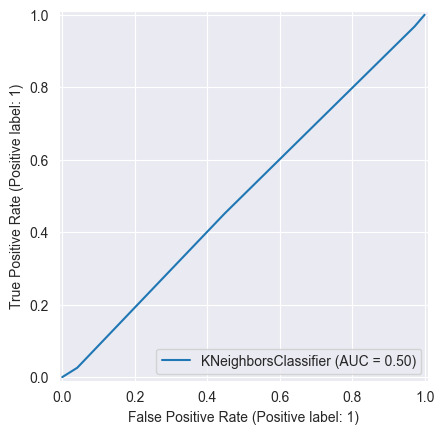

In [972]:
#Curva ROC
RocCurveDisplay.from_estimator(knn, X_test, y_test)

### Modelo 4: Gaussian Naive Bayes
### Análise e ajuste dos hiper-parâmetros da Naive Bayes

In [973]:
NBclassifier1 = GaussianNB()
NBclassifier1.fit(X_train, y_train)

y_pred = NBclassifier1.predict(X_test)

print(classification_report(y_test, y_pred))
print('Matriz de confusão: ')
print(confusion_matrix(y_test, y_pred))
acc_gaussian = round(NBclassifier1.score(X_train, y_train) * 100, 2)
NBAcc1 = accuracy_score(y_pred,y_test)
print('Acurácia do algoritmo de Naive Bayes: {:.2f}%'.format(NBAcc1*100))

              precision    recall  f1-score   support

           0       0.49      0.26      0.34       145
           1       0.52      0.74      0.61       155

    accuracy                           0.51       300
   macro avg       0.50      0.50      0.48       300
weighted avg       0.50      0.51      0.48       300

Matriz de confusão: 
[[ 38 107]
 [ 40 115]]
Acurácia do algoritmo de Naive Bayes: 51.00%


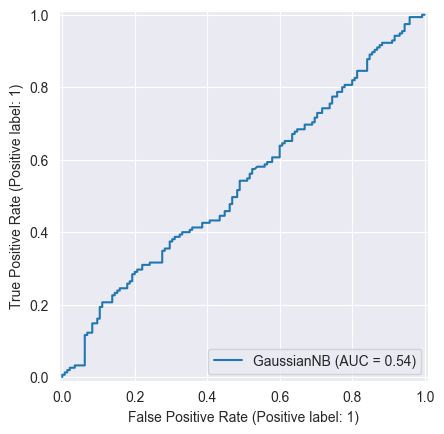

In [974]:
#Curva ROC
RocCurveDisplay.from_estimator(NBclassifier1, X_test, y_test)

### Modelo 5: Random Forest
### Análise e ajuste dos hiper-parâmetros de Random Foest

In [975]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
acc_rf_train = round(rf.score(X_train, y_train) * 100, 2)
acc_rf_test = round(rf.score(X_test, y_test) * 100, 2)
print(f"Acurácia no conjunto de treino (Random Forest): {acc_rf_train}%")
print(f"Acurácia no conjunto de teste (Random Forest): {acc_rf_test}%")

Acurácia no conjunto de treino (Random Forest): 72.43%
Acurácia no conjunto de teste (Random Forest): 53.67%


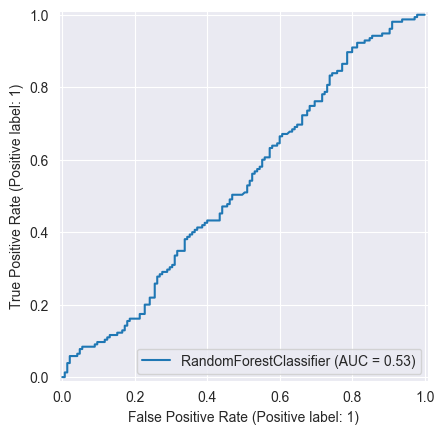

In [976]:
#Curva ROC
RocCurveDisplay.from_estimator(rf, X_test, y_test)

In [977]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Gaussian Naive Bayes',
              'Decision Tree'],
    'Score': [acc_knn, acc_log, 
              acc_rf_train, acc_gaussian,
             acc_decision_tree_train]})
models.sort_values(by='Score', ascending=False)




,Model,Score
0,KNN,75.29
2,Random Forest,72.43
4,Decision Tree,65.57
3,Gaussian Naive Bayes,55.86
1,Logistic Regression,55.43
